# Title TBD:

(c) 2020 Manuel Razo & Daniela Osorio. This work is licensed under a 
[Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). 
All code contained herein is licensed under an 
[MIT license](https://opensource.org/licenses/MIT).

In [2]:
import glob

# Numerical analysis libraries
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr

# Interface to Stan
import cmdstanpy
import arviz as az

# Find home directory for repo
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

## Explanation of what we are doing here (by Daniela)

## Exploratory Data Analysis

Before jumping into the analysis let's do a quick exploration of the data. First, we need to import the data form all enzymes into memory.

In [39]:
# List files to be read
files = glob.glob(f"{homedir}/data/processed/enzymes/*csv")

# Read all files into dataframe
df = pd.concat(map(pd.read_csv, files))
# Remove unnecessary column
df = df.drop('Unnamed: 0', axis=1)

# Print unique enzymes
print(f"enzymes: {df.Name.unique()}")
df.head()

enzymes: ['DddD' 'DddP' 'DddK' 'Alma1' 'DmdA' 'DddY' 'DddQ']


,Name,d34S,Replicate,Time_min,ID,f_R,Real_conc,minus_ln_f_R,d34S_approx,r34_approx,f34_approx,conc_s_cell_lysate,F34_approx_DMSP,R34_approx_DMSP,d34S_approx_DMSP
0,DddD,12.410000,b,0,DddD_0_b,1.000000,95.300000,0.000000,12.333627,0.045560,0.043574,37.508476,0.043645,0.045637,14.044276
1,DddD,11.498627,b,4,DddD_4_b,0.721417,68.750996,0.326539,11.433021,0.045519,0.043537,37.508476,0.043615,0.045604,13.312725
2,DddD,13.121328,b,11,DddD_11_b,0.497228,47.385801,0.698707,13.035989,0.045591,0.043603,37.508476,0.043768,0.045771,17.032980
3,DddD,12.707020,b,18,DddD_18_b,0.303706,28.943204,1.191694,12.626963,0.045573,0.043586,37.508476,0.043834,0.045843,18.640973
4,DddD,12.973279,b,25,DddD_25_b,0.241314,22.997230,1.421656,12.889847,0.045585,0.043597,37.508476,0.043926,0.045945,20.888524


Having imported the data, let's look at the plot of (Dani) (column `minus_ln_f_R`) vs. (Dani) (col `d34S_approx_DMSP`)

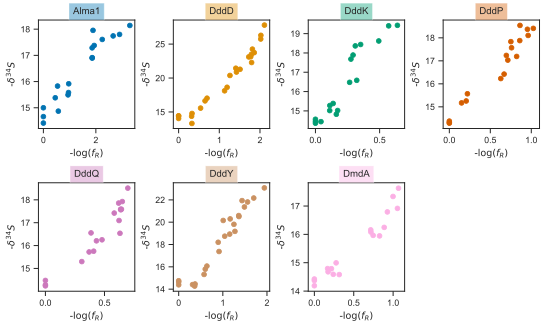

In [47]:
# Group data by enzyme
df_group = df.groupby("Name")

# Define colors
colors = sns.color_palette("colorblind", n_colors=len(df_group))
# Initialize figure
fig, ax = plt.subplots(2, 4, figsize=(9, 5))

# ravel ax
ax = ax.ravel()

# Loop through enzymes
for i, (enzyme, data) in enumerate(df_group):
    # Plot minus_ln_f_R vs d34S_approx_DMSP
    ax[i].scatter(data["minus_ln_f_R"], data["d34S_approx_DMSP"], color=colors[i])
    
    # Set plot title
    ax[i].set_title(f"{enzyme}", bbox=dict(facecolor=colors[i], alpha=0.4))
    
    # Set axis labels
    ax[i].set_xlabel(r"-$\log (f_R)$")
    ax[i].set_ylabel(r"-$\delta ^{34}S$")
    
# Increase spacing among subplots
plt.subplots_adjust(hspace=0.5, wspace=0.4)

# Remove last plot
ax[-1].axis("off");

We can see that, as expected, there is a linear correlation between (Dani) and (Dani). In order to compute the (Dani, fractionation factor?) we then need to estimate the slope of this linear regression. This, being one of the main results of our work, deserves a careful analysis. Therefore, rather than performing a simple ordinary least-squares or even a maximum likelihood estimate, we will perform a Bayesian linear regression to obtain this slope.

## Bayesian linear regression.

In Bayesian parameter inference we are concerned with learning the probability distribution over the quantities that parametrize our models. For the particular case of this linear regression let us define $x \equiv \log(f_R)$ and $y \equiv -\delta S^{34}$. Our simple linear regression model then takes the form of
$$
y_i = m x_i + b + \varepsilon_i,
$$
where $m$ is the slope we are interested in, $b$ is the $y-$axis intercept, and $\varepsilon_i$ is a random error associated with the intrinsic experimental errors. We take these errors to be random, i.e., we can only describe them probabilistically. As it is commonly done, we will assume that these errors are normally distributed, i.e.,
$$
\varepsilon_i = y_i - (m x_i + b) \sim \mathcal{N}(0, \sigma^2).
$$
What this equation is telling us is that we expect the random errors to have a mean of zero (positive and negative errors are equally likely, canceling each other), and they are characterized by an unknown variance $\sigma^2$.

So the objective of our Bayesian regression is to compute the so-called posterior probability distribution $P(m, b, \sigma^2 \mid D)$, where $D \equiv \{x_1, x_2, \ldots, x_N \}$, is the data. We can then write Bayes theorem as
$$
P(m, b, \sigma^2 \mid D) = \frac{P(D \mid m, b, \sigma^2)P(m, b, \sigma^2)}{P(D)}
\propto P(D \mid m, b, \sigma^2)P(m, b, \sigma^2).
$$
For the second equality we ignore the denominator $P(D)$ since it does not depend on our parameter values, and therefore only serves as a normalization constant.

Let's now analyze the two relevant terms.

### The likelihood $P(D \mid m, b, \sigma^2)$

The likelihood term, called like this because it reflects how likely it is to observe our data $D$ given a particular choice of parameter values $m, b$, and $\sigma^2$, is what ...

### Marginal probability distribution of slope $P(m \mid D)$

$$
m \mid y_{1}, \cdots, y_{n} \sim \mathrm{t}\left(n-2, \hat{m}, \frac{\hat{\sigma}^{2}}{\mathrm{S}_{x x}}\right)
$$

$$
b \mid y_{1}, \cdots, y_{n} \sim \mathrm{t}\left(n-2, \hat{b}, \hat{\sigma}^{2}\left(\frac{1}{n}+\frac{\bar{x}^{2}}{\mathrm{S}_{x x}}\right)\right)
$$

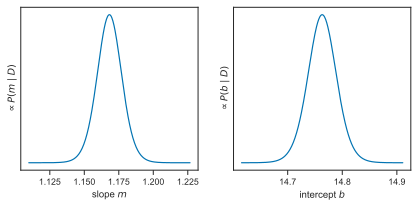

In [70]:
# Select example dataframe
df_example = df[df.Name == "Alma1"]

# Extract x and y data
x = df_example["minus_ln_f_R"]
y = df_example["d34S_approx_DMSP"]

# Fit 1D polynomial with numpy
# This is equivalent to finding the mean of the distribution
m_hat, b_hat = np.polyfit(x, y, 1)

# Define distribution parameters
n = len(df_example)  # number of datum
d_freedom = n - 2  # Degrees of freedom
sigma_sq = np.sum((y - (m_hat * x + b_hat))**2) / d_freedom  # mean squared error
S_xx = np.sum((x - np.mean(x))**2)  # sum of squares

# Compute error for slope
m_err = sigma_sq / S_xx
# Compute error for intercept
b_err = sigma_sq * (1 / n + np.mean(x)**2 / S_xx)

# Define range to evaluate slope distribution
m_range = np.linspace(0.95 * m_hat, 1.05 * m_hat, 300)
# Evaluate distribution
m_pdf = sp.stats.t.pdf(m_range, d_freedom, m_hat, m_err)

# Define range to evaluate intercept distribution
b_range = np.linspace(0.99 * b_hat, 1.01 * b_hat, 300)
# Evaluate distribution
b_pdf = sp.stats.t.pdf(b_range, d_freedom, b_hat, b_err)

# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Plot slope distribution
ax[0].plot(m_range, m_pdf)
# Label axis
ax[0].set_xlabel(r"slope $m$")
ax[0].set_ylabel(r"$\propto P(m \mid D)$")
# Remove y axis ticks
ax[0].set_yticks([])

# Plot interecept distribution
ax[1].plot(b_range, b_pdf)
# Label axis
ax[1].set_xlabel(r"intercept $b$")
ax[1].set_ylabel(r"$\propto P(b \mid D)$")
# Remove y axis ticks
ax[1].set_yticks([])

# Adjust plot spacing
plt.subplots_adjust(wspace=0.2)

By eye, these distributions seem reasonable. Let's now compute the 95% **credible region** for both parameters

In [76]:
# Define percentiles
percentiles = [0.025, 0.975]

# Compute percentiles for slope
m_per = [sp.stats.t.ppf(x, d_freedom, m_hat, m_err) for x in percentiles]

# Compute percentiles for intercept
b_per = [sp.stats.t.ppf(x, d_freedom, b_hat, b_err) for x in percentiles]

# Print results
print(f"slope: {np.round(m_hat, 2)} + " +
      f"{np.round(m_per[1] - m_hat, 2)} - " +
      f"{np.round(m_hat - m_per[0], 2)}")

print(f"intercept: {np.round(b_hat, 2)} + " +
      f"{np.round(b_per[1] - b_hat, 2)} - " +
      f"{np.round(b_hat - b_per[0], 2)}")

slope: 1.17 + 0.02 - 0.02
intercept: 14.76 + 0.05 - 0.05
